In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Instalar unrar para descompirmir los archivos .rar
!apt-get install unrar
!pip install rarfile

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
import os
import rarfile

# Asegúrate de tener rarfile instalado:
# !pip install rarfile
# También puede requerir unrar en el entorno local: sudo apt install unrar

# Ruta del archivo RAR
rar_folder = "/content/drive/MyDrive/SIS421/Laboratorios/Datasets/Dataset_Lab05"
output_folder = "/content/flores_dataset"

os.makedirs(output_folder, exist_ok=True)

# Buscar archivo .rar en la carpeta
rar_files = [f for f in os.listdir(rar_folder) if f.endswith(".rar")]

if len(rar_files) == 1:
    rar_file = rar_files[0]
    rar_path = os.path.join(rar_folder, rar_file)
    flower_class = os.path.splitext(rar_file)[0]
    flower_dir = os.path.join(output_folder, flower_class)
    os.makedirs(flower_dir, exist_ok=True)

    with rarfile.RarFile(rar_path) as rf:
        rf.extractall(flower_dir)

    print(f"✔️ {rar_file} extraído en {flower_class}/")

elif len(rar_files) == 0:
    print("⚠️ No se encontró ningún archivo .rar en la carpeta.")
else:
    print("⚠️ Hay más de un archivo .rar, selecciona uno o adapta el código.")


✔️ Dataset_lab05.rar extraído en Dataset_lab05/


In [ ]:
from PIL import Image

deleted = 0
for root, _, files in os.walk(output_folder):
    for file in files:
        path = os.path.join(root, file)
        try:
            with Image.open(path) as img:
                if img.size[0] < 40 or img.size[1] < 40:
                    os.remove(path)
                    deleted += 1
        except:
            os.remove(path)
            deleted += 1

print(f"🧹 Total imágenes eliminadas: {deleted}")


🧹 Total imágenes eliminadas: 0


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = datasets.ImageFolder("/content/flores_dataset/Dataset_lab05/Dataset_lab05", transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

print(f"🌸 Dataset listo con {len(dataset)} imágenes en {len(dataset.classes)} clases: {dataset.classes}")


🌸 Dataset listo con 5000 imágenes en 5 clases: ['Clavel_estrella', 'Flor_alfa', 'Matricaria_Tetra_Blanca', 'Montecasino', 'Rafines']


In [ ]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Entrada: ruido (nz) x 1 x 1
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),  # (ngf*8) x 4 x 4
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),  # (ngf*4) x 8 x 8
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),  # (ngf*2) x 16 x 16
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),  # (ngf) x 32 x 32
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),  # (nc) x 64 x 64
            nn.Tanh()  # Normaliza entre [-1, 1]
        )

    def forward(self, input):
        return self.main(input)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),   # 32x32
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),  # 16x16
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),  # 8x8
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),  # 4x4
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),  # 1x1
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1)


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from pathlib import Path

# Directorio para guardar checkpoints (añade esto al inicio del código)
CHECKPOINT_DIR = "/content/drive/MyDrive/SIS421/Laboratorios/Datasets/Dataset_Lab05"
Path(CHECKPOINT_DIR).mkdir(parents=True, exist_ok=True)  # Crea la carpeta si no existe

# Parámetros
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nz, ngf, ndf, nc = 100, 64, 64, 3  # ruido, filtros generador/discriminador, canales

netG = Generator(nz, ngf, nc).to(device)
netD = Discriminator(nc, ndf).to(device)

criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs = 20

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        ############################
        # (1) Actualizar Discriminador
        ############################
        netD.zero_grad()
        real_images = real_images.to(device)
        b_size = real_images.size(0)

        real_labels = torch.ones(b_size, device=device)
        fake_labels = torch.zeros(b_size, device=device)

        output_real = netD(real_images)
        loss_real = criterion(output_real, real_labels)

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netG(noise)

        output_fake = netD(fake_images.detach())
        loss_fake = criterion(output_fake, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizerD.step()

        ############################
        # (2) Actualizar Generador
        ############################
        netG.zero_grad()
        fake_labels.fill_(1.0)  # queremos engañar al discriminador

        output = netD(fake_images)
        loss_G = criterion(output, fake_labels)
        loss_G.backward()
        optimizerG.step()

    # Guardar checkpoint por época
    checkpoint_path = f"{CHECKPOINT_DIR}/checkpoint_epoch_{epoch+1}.pt"
    torch.save({
        'epoch': epoch + 1,
        'netG_state_dict': netG.state_dict(),
        'netD_state_dict': netD.state_dict(),
        'optimizerG_state_dict': optimizerG.state_dict(),
        'optimizerD_state_dict': optimizerD.state_dict(),
        'loss_G': loss_G.item(),
        'loss_D': loss_D.item()
    }, checkpoint_path)
    print(f"✔️ Checkpoint guardado en {checkpoint_path}")
    print(f"[{epoch+1}/{num_epochs}] Loss_D: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f}")


✔️ Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/Dataset_Lab05/checkpoint_epoch_1.pt
[1/20] Loss_D: 0.2324 Loss_G: 4.1550
✔️ Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/Dataset_Lab05/checkpoint_epoch_2.pt
[2/20] Loss_D: 0.6919 Loss_G: 0.7600
✔️ Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/Dataset_Lab05/checkpoint_epoch_3.pt
[3/20] Loss_D: 0.4340 Loss_G: 2.9917
✔️ Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/Dataset_Lab05/checkpoint_epoch_4.pt
[4/20] Loss_D: 0.6150 Loss_G: 4.0276
✔️ Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/Dataset_Lab05/checkpoint_epoch_5.pt
[5/20] Loss_D: 0.7430 Loss_G: 2.1193
✔️ Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/Dataset_Lab05/checkpoint_epoch_6.pt
[6/20] Loss_D: 2.1631 Loss_G: 1.0075
✔️ Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/Dataset_Lab05/ch

In [ ]:
#Si fueras a cargar el modelo
checkpoint = torch.load("checkpoints/content/drive/MyDrive/SIS421/Laboratorios/Datasets/checkpoint_epoch_20.pt")
netG.load_state_dict(checkpoint['netG_state_dict'])
netD.load_state_dict(checkpoint['netD_state_dict'])
optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])
start_epoch = checkpoint['epoch'] + 1

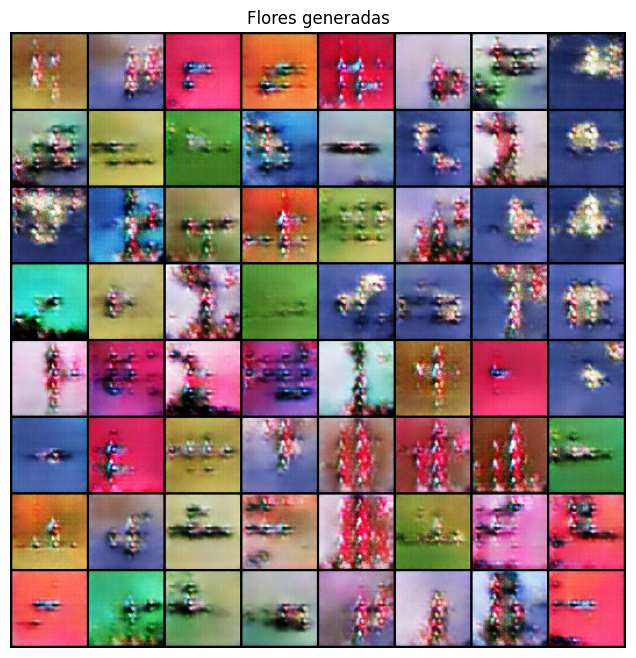

In [ ]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt

fake_images = netG(fixed_noise).detach().cpu()
grid = vutils.make_grid(fake_images, padding=2, normalize=True)

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Flores generadas")
plt.imshow(grid.permute(1, 2, 0))
plt.show()


#Aplicando Metricas

In [ ]:
import torch
import os
import matplotlib.pyplot as plt

CHECKPOINT_DIR = "/content/drive/MyDrive/SIS421/Laboratorios/Datasets/Dataset_Lab05"

# Listar checkpoints ordenados por época
checkpoints = sorted([f for f in os.listdir(CHECKPOINT_DIR) if f.endswith(".pt")])

epochs = []
losses_D = []
losses_G = []

for filename in checkpoints:
    checkpoint = torch.load(os.path.join(CHECKPOINT_DIR, filename), map_location='cpu')
    epochs.append(checkpoint['epoch'])
    losses_D.append(checkpoint['loss_D'])
    losses_G.append(checkpoint['loss_G'])

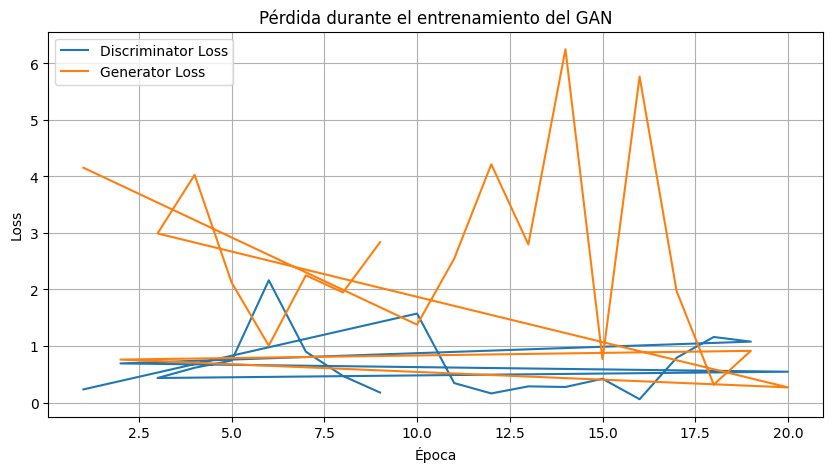

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, losses_D, label="Discriminator Loss")
plt.plot(epochs, losses_G, label="Generator Loss")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Pérdida durante el entrenamiento del GAN")
plt.grid(True)
plt.legend()
plt.show()


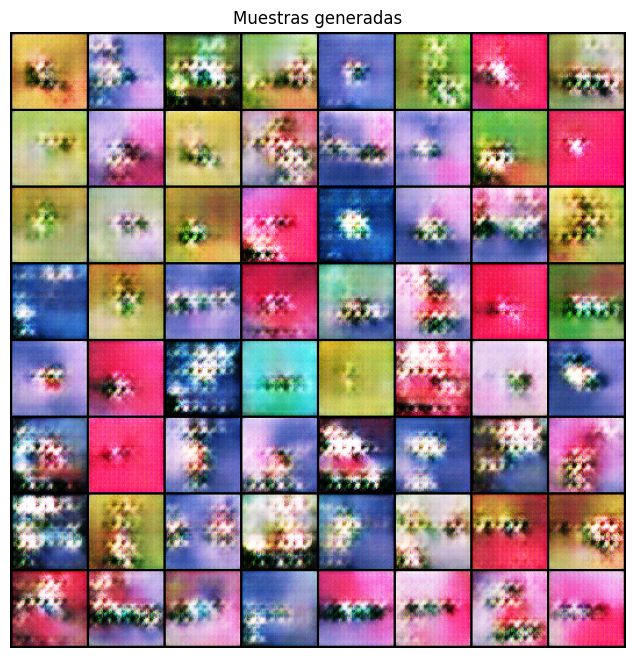

In [ ]:
# Cargar generador desde el último checkpoint
checkpoint = torch.load(os.path.join(CHECKPOINT_DIR, checkpoints[-1]), map_location=device)
netG.load_state_dict(checkpoint['netG_state_dict'])
netG.to(device).eval()

# Usar fixed_noise o crear uno nuevo
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
with torch.no_grad():
    fake_images = netG(fixed_noise).cpu()

# Visualizar
import torchvision.utils as vutils

grid = vutils.make_grid(fake_images, normalize=True, scale_each=True, nrow=8)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))
plt.title("Muestras generadas")
plt.axis("off")
plt.show()
